In [1]:
# 머신러닝
# 텐서플로우 종속성 추가
import tensorflow as tf
print("TensorFlow version:", tf.__version__)    # 텐서플로우 버전 확인


TensorFlow version: 2.15.0


In [2]:
# 모델 구조 생성
model = tf.keras.models.Sequential([                  # Sequential 모델 정의 및 생성
    tf.keras.layers.Flatten(input_shape = (500, 500)),  # (500, 500) 픽셀의 2차원 데이터를 1차원으로 평탄화
    tf.keras.layers.Dense(128, activation = 'relu'),  # 128개의 출력 뉴런을 가지고 relu 활성화 함수를 사용해 확률을 계산한다
                                                      # relu 출력값을 0 이상의 값으로 변환한다
    tf.keras.layers.Dropout(0.2),                     # 과적합 방지, 무작위 뉴런 20%의 출력을 무시
    tf.keras.layers.Dense(5, activation = 'softmax') # 5개의 출력 뉴런을 가지고 softmax 활성화 함수를 사용해 확률을 계산한다
                                                      # softmax 출력값을 확률로 변환 0 또는 1로 표현한다
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 250000)            0         
                                                                 
 dense (Dense)               (None, 128)               32000128  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 32000773 (122.07 MB)
Trainable params: 32000773 (122.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
# 전이학습
path = '/content/drive/MyDrive/test/dogs'    # 경로 설정

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [12]:
# 데이터 불러오기
dataset = tf.keras.utils.image_dataset_from_directory(path,                     # 이미지 경로
                                                      shuffle=True,             # 데이터를 섞을 지 여부
                                                        batch_size=5,          # 데이터 배치 크기(1~5)
                                                        image_size=(500, 500))  # 이미지 크기 조정(height, width)

Found 50 files belonging to 5 classes.


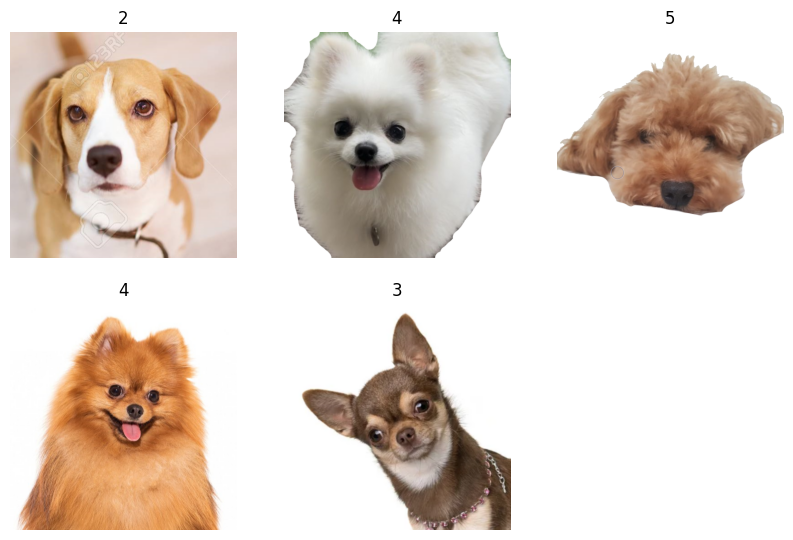

In [14]:
# 라벨 확인
class_names = dataset.class_names                     # 데이터의 클레스 이름을 리스트로 반환

plt.figure(figsize=(10, 10))                          # 그림 객체 생성, figsize 그림의 크기 지정(단위 인치)
for images, labels in dataset.take(1):
    for i in range(5):
        ax = plt.subplot(3, 3, i + 1)                 # 서브플롯 생성 (행, 열, 위치)
        plt.imshow(images[i].numpy().astype("uint8")) # 이미지 표시
        plt.title(class_names[labels[i]])             # 이름 설정
        plt.axis("off")                               # 축 표시 x

In [15]:
# 배치 크기로 나누기
batches = tf.data.experimental.cardinality(dataset)     # 데이터셋의 크기
train_dataset = dataset.take(batches * 4 // 5)          # 앞의 80 퍼센트의 데이터를 훈련 데이터로 한다
test_dataset = dataset.skip(batches * 4 // 5)           # 앞의 80 퍼센트를 건너 뛴 나머지 20 퍼센트의 데이터를 테스트 데이터로 한다

print(tf.data.experimental.cardinality(train_dataset))
print(tf.data.experimental.cardinality(test_dataset))

tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)


In [16]:
# 성능향상
# 버퍼링된 프리패치로 I/O 차단 없이 디스크에서 이미지 로드(성능향상)
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

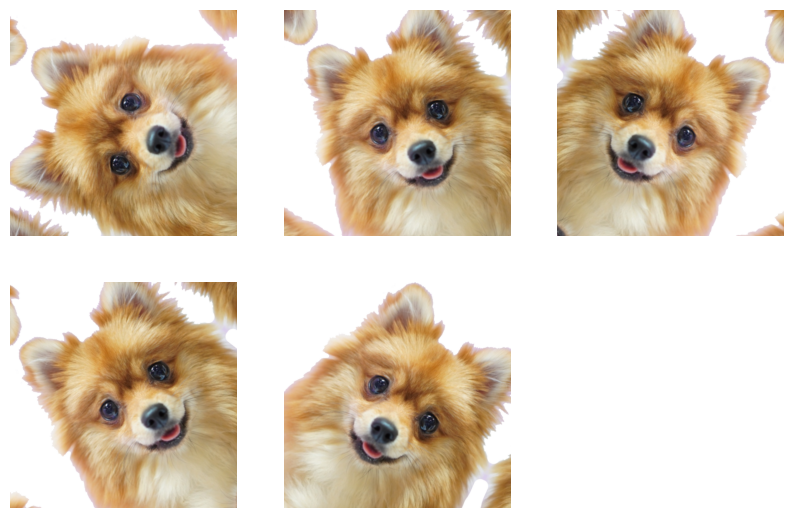

In [17]:
# 데이터 증강 사용
data_augmentation = tf.keras.Sequential([                                       # 이미지 증강
    tf.keras.layers.RandomFlip('horizontal'),                                   # 이미지 랜덤하게 뒤집기
    tf.keras.layers.RandomRotation(0.2),                                        # 이미지 랜덤하게 회전(±20도)
])

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]

    for i in range(5):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [18]:
# 픽셀값 재조정
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input    # mobilenet_v2 이미지 분류 모델 활용
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)                  # 픽셀값 재조정 -1 ~ 1 의 값, 모델에 맞게 사용

In [19]:
# 전이학습의 기본 모델 설정
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (500, 500) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,   # MobileNetV2 모델을 설정 # 입력받을 이미지의 크기
                                               include_top=False,       # 최상위 레이어을 포함하지 않음
                                               weights='imagenet')      # ImageNet에서 사전 학습 된 가중치를 적용

9406464/9406464 [==============================] - 1s 0us/step


In [20]:
# 베이스 모델로의 변환 확인
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(5, 16, 16, 1280)


In [21]:
# 베이스 모델 학습 하지 않음
base_model.trainable = False

In [22]:
# 입력 이미지를 모델에 맞게 변환
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(5, 1280)


In [23]:
# 모델의 출력부 확인
prediction_layer = tf.keras.layers.Dense(5)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(5, 5)


In [24]:
# 모델 생성
inputs = tf.keras.Input(shape=(500, 500, 3))  # 입력 레이어 설정
x = data_augmentation(inputs)                 # 데이터 증강
x = preprocess_input(x)
x = base_model(x, training=False)             # 쓰려는 모델, 학습 x, 우리 데이터로 학습할거기 때문
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)           # 과적합 방지, 20프로 무시
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [30]:
# 모델 컴파일
base_learning_rate = 0.00001   # 머신러닝의 학습률
# 학습 구성 설정 # 활성화 함수 Adam
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [31]:
# 모델의 학습 가능 매개변수 확인
len(model.trainable_variables)

2

In [32]:
initial_epochs = 10

In [33]:
# 학습 진행
# 10 학습 후 결과
history = model.fit(train_dataset,                  # 모델 학습 함수
                    epochs=initial_epochs,          # 반복 횟수 설정
                    validation_data=test_dataset)   # 검증용 데이터

Epoch 1/10
8/8 [==============================] - 5s 217ms/step - loss: 1.3798 - accuracy: 0.4750 - val_loss: 1.4143 - val_accuracy: 0.4000
Epoch 2/10
8/8 [==============================] - 1s 101ms/step - loss: 1.3926 - accuracy: 0.4250 - val_loss: 1.4772 - val_accuracy: 0.5000
Epoch 3/10
8/8 [==============================] - 1s 100ms/step - loss: 1.4370 - accuracy: 0.5000 - val_loss: 1.4068 - val_accuracy: 0.3000
Epoch 4/10
8/8 [==============================] - 1s 130ms/step - loss: 1.4528 - accuracy: 0.4750 - val_loss: 1.3493 - val_accuracy: 0.5000
Epoch 5/10
8/8 [==============================] - 1s 103ms/step - loss: 1.4338 - accuracy: 0.4250 - val_loss: 1.3728 - val_accuracy: 0.4000
Epoch 6/10
8/8 [==============================] - 2s 223ms/step - loss: 1.4407 - accuracy: 0.4000 - val_loss: 1.3127 - val_accuracy: 0.7000
Epoch 7/10
8/8 [==============================] - 2s 237ms/step - loss: 1.3390 - accuracy: 0.5500 - val_loss: 1.4006 - val_accuracy: 0.4000
Epoch 8/10
8/8 [====

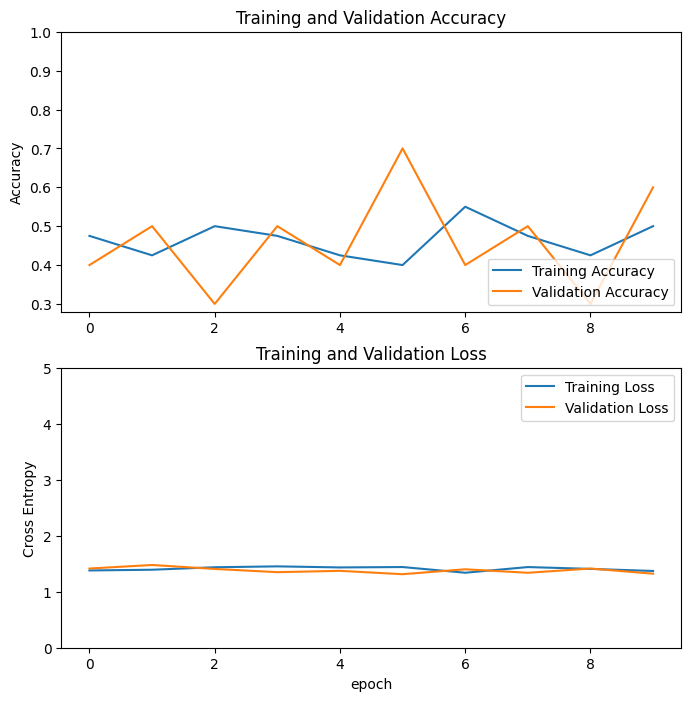

In [34]:
# 정확도, 오차 그래프 추적
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [35]:
# 훈련, 테스트 데이터의 정확도 확인
loss, accuracy = model.evaluate(train_dataset)  # train_dataset에 대한 손실값과 정확도 계산
print('Train accuracy :', accuracy)

loss, accuracy = model.evaluate(test_dataset)   # test_dataset에 대한 손실값과 정확도 계산
print('Test accuracy :', accuracy)

8/8 [==============================] - 1s 41ms/step - loss: 1.4260 - accuracy: 0.4500
Train accuracy : 0.44999998807907104
2/2 [==============================] - 0s 38ms/step - loss: 1.5674 - accuracy: 0.3000
Test accuracy : 0.30000001192092896


1/1 [==============================] - 0s 45ms/step


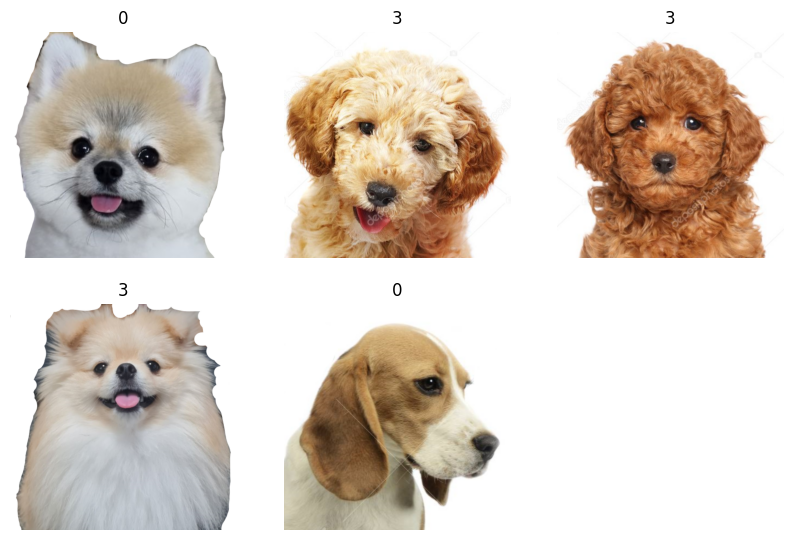

In [38]:
# 학습한 모델의 예측 값 확인
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict(image_batch)

label = predictions.argmax(axis=1)

plt.figure(figsize=(10, 10))    # 예측값 시각화
for i in range(5):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(label[i])
    plt.axis("off")